<a href="https://colab.research.google.com/github/prasanth5reddy/D2L/blob/master/Multilayer%20Perceptrons/predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/D2L.AI/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip install mxnet

Importing Libraries

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import d2l
import mxnet as mx
from mxnet import nd, autograd, gluon, init
from mxnet.gluon import data as gdata, loss as gloss, nn

Accessing and Reading Data Sets

In [4]:
train_data = pd.read_csv(w_dir + 'data/kaggle_house_pred_train.csv')
test_data = pd.read_csv(w_dir + 'data/kaggle_house_pred_test.csv')

train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
# remove id as it makes no sense
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]])
all_features.shape

(2919, 79)

Data Preprocessing

In [0]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())

# set missing values to mean i.e zero
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
non_numeric_features = [col for col in all_features.columns if col not in numeric_features]
all_features[non_numeric_features].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,...,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,...,1723,1230,2604,2654,2641,4,329,95,2525,2402


In [9]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and 
# creates an indicative feature for it

all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [10]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data['SalePrice'].values).reshape(-1, 1)

train_features.shape, train_labels.shape, test_features.shape

((1460, 331), (1460, 1), (1459, 331))

Training

In [0]:
loss = gloss.L2Loss()

def get_net():
  net = nn.Sequential()
  net.add(nn.Dense(16, activation='relu'))
  net.add(nn.Dense(1))
  net.initialize()
  return net

In [0]:
def log_rmse(net, features, labels):
  # To further stabilize the value when the logarithm is taken, set the
  # value less than 1 as 1
  clipped_preds = nd.clip(net(features), 1, float('inf'))
  rmse = nd.sqrt( 2 * loss(clipped_preds.log(), labels.log()).mean())
  return rmse.asscalar()

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
  # Adam optimization
  trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      trainer.step(batch_size)
      
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  
  return train_ls, test_ls

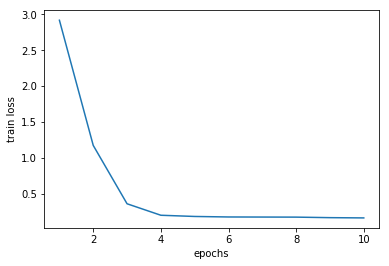

In [14]:
train_ls, test_ls = train(get_net(), train_features, train_labels, None, None, num_epochs=10, learning_rate=0.1, weight_decay=0, batch_size=32)

plt.plot(nd.arange(1, 11).asnumpy(), np.array(train_ls))
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.show()

K-Fold Cross-Validation

In [0]:
def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train, X_valid, y_valid = None, None, None, None
  for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = nd.concat(X_train, X_part, dim=0)
      y_train = nd.concat(y_train, y_part, dim=0)
      
  return X_train, y_train, X_valid, y_valid
  

In [0]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
    
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
    print('fold %d, train rmse: %f, valid rmse: %f' % (i, train_ls[-1], valid_ls[-1]))
  return train_l_sum / k, valid_l_sum / k
      

Model Selection

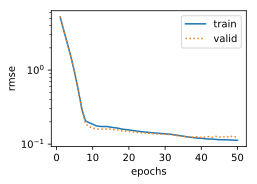

fold 0, train rmse: 0.112652, valid rmse: 0.128191
fold 1, train rmse: 0.109115, valid rmse: 0.140341
fold 2, train rmse: 0.110739, valid rmse: 0.131838
fold 3, train rmse: 0.121008, valid rmse: 0.120925
fold 4, train rmse: 0.106310, valid rmse: 0.152591
5-fold validation: avg train rmse: 0.111965, avg valid rmse: 0.134777


In [17]:
k , num_epochs, lr, weight_decay, batch_size = 5, 50, 0.1, 50, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'% (k, train_l, valid_l))

Predict and Submit

In [0]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
  d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
  print('train rmse %f' % train_ls[-1])
  #Apply the network to test set
  preds = net(test_features).asnumpy()
  # Reformat it for export to kaggle
  test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv', index=False)

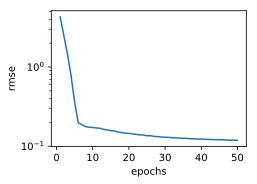

train rmse 0.118750


In [19]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)